# Exercise 3

## 1 Introduction

Task: Install pytorch (best with conda), convert intro.py into a Jupyter notebook and run the code.

Epoch: 0
Mean Train Loss: 3.90e-01
Mean Test Loss:  2.21e-01
Epoch: 10
Mean Train Loss: 1.59e-01
Mean Test Loss:  2.89e-01
Epoch: 20
Mean Train Loss: 1.08e-01
Mean Test Loss:  3.77e-01
Epoch: 30
Mean Train Loss: 8.29e-02
Mean Test Loss:  5.40e-01
Epoch: 40
Mean Train Loss: 5.47e-02
Mean Test Loss:  6.73e-01
Epoch: 50
Mean Train Loss: 3.86e-02
Mean Test Loss:  7.01e-01
Epoch: 60
Mean Train Loss: 2.78e-02
Mean Test Loss:  8.03e-01
Epoch: 70
Mean Train Loss: 2.37e-02
Mean Test Loss:  1.03e+00
Epoch: 80
Mean Train Loss: 1.60e-02
Mean Test Loss:  1.02e+00
Epoch: 90
Mean Train Loss: 1.64e-02
Mean Test Loss:  9.33e-01
Epoch: 100
Mean Train Loss: 1.36e-02
Mean Test Loss:  8.53e-01


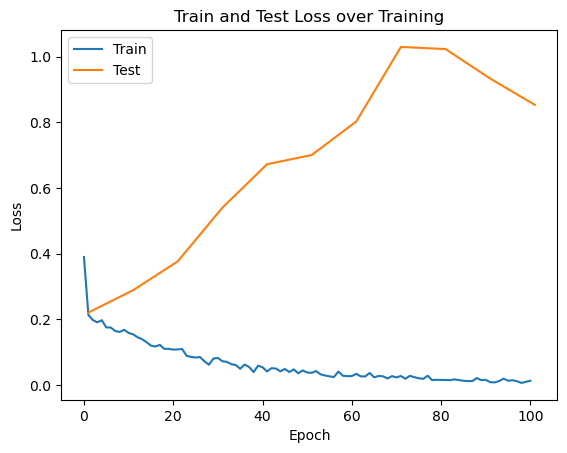

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.legend()


## 2 Dropout

We want to use dropout learning for out network. Therefore, implement the function:

        def dropout(X, p_drop=0.5): ...
        
that sets random elements of X to zero (do not use pytorch's existing dropout functionality).
Dropout:

* If 0< pdrop <1:
    For every element xi ∈ X draw Φi randomly from a binomial distribution with p = pdrop.
    Then reassign
            xi →    {0              if Φ = 1,
                    xi / (1−pdrop)  if Φ = 0}
* Else:
    Return the unchanged X.

In [2]:
def dropout(X, p_drop=0.5):
    if 0 < p_drop < 1:
        # randomly mask elements of X based on binomial distribution
        mask = np.random.binomial(1, p=p_drop, size=X.shape).astype(bool)
        # copy of X is created using X.clone() to avoid modifying the original tensor
        X_drop = X.clone()
        X_drop[mask] = 0
        X_drop /= (1 - p_drop)
        return X_drop
    else:
        return X

You can now enable the dropout functionality. To this end, implement a new model
        
        def dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden): ...
        
containing the same fully-connected layers as in function model() of task 1, but now with three dropout steps. Dropout is applied to the input of each layer.

In [3]:
def dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    # apply dropout to the input layer
    x = dropout(x, p_drop_input)

    # first hidden layer
    h = rectify(x @ w_h)
    # apply dropout to the first hidden layer
    h = dropout(h, p_drop_hidden)

    # second hidden layer
    h2 = rectify(h @ w_h2)
    # apply dropout to the second hidden layer
    h2 = dropout(h2, p_drop_hidden)

    # output layer
    pre_softmax = h2 @ w_o
    return pre_softmax

Task: Explain in a few sentences how the dropout method works and how it reduces overfitting. Train the model using dropout and report train and test errors. Why do we need a different model configuration for evaluating the test loss? Compare the test error with the test error from Section 1.


* The dropout model works by randomly setting a part of the neurons to zero on each iteration of the training process. By doing so it drops out those parts and this enables the network to learn more robust and generalized features. The model becomes more independent beacuse it works with neurons that are partly dropped out and it cannot rely on specific neurons. This leads the creation of multiple subnetworks which improves the network's generalization ability and reduces overfitting.

Epoch: 0
Mean Train Loss: 2.93e+00
Mean Test Loss:  2.08e-01
Epoch: 10
Mean Train Loss: 8.65e-01
Mean Test Loss:  2.36e-01
Epoch: 20
Mean Train Loss: 9.60e-01
Mean Test Loss:  2.43e-01
Epoch: 30
Mean Train Loss: 1.08e+00
Mean Test Loss:  3.18e-01
Epoch: 40
Mean Train Loss: 1.15e+00
Mean Test Loss:  3.36e-01
Epoch: 50
Mean Train Loss: 1.18e+00
Mean Test Loss:  3.47e-01
Epoch: 60
Mean Train Loss: 1.20e+00
Mean Test Loss:  3.96e-01
Epoch: 70
Mean Train Loss: 1.24e+00
Mean Test Loss:  4.33e-01
Epoch: 80
Mean Train Loss: 1.35e+00
Mean Test Loss:  4.44e-01
Epoch: 90
Mean Train Loss: 1.33e+00
Mean Test Loss:  4.51e-01
Epoch: 100
Mean Train Loss: 1.45e+00
Mean Test Loss:  5.28e-01


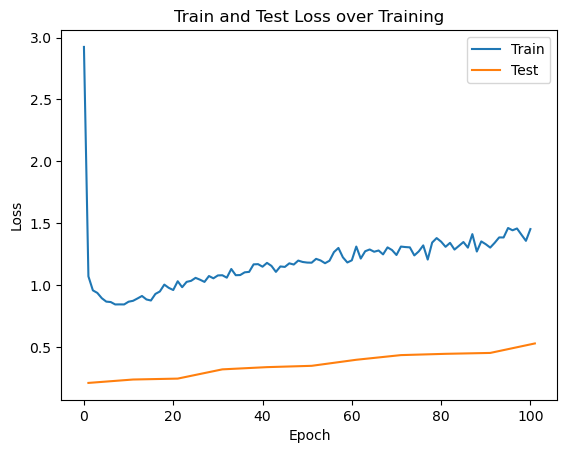

In [4]:
# Set dropout probabilities
p_drop_input = 0.2
p_drop_hidden = 0.5

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model with dropout
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                # feed input through model without dropout during testing
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.legend()


* During evaluation or testing, we want to assess the performance of the network without dropout regularization. We want to see how well the network performs when all neurons are active and producing their full outputs. Therefore, we evaluate the test loss using the model configuration without dropout.

* The test loss, which indicates how well the model performs on unseen data is consistently lower in Section 2 than it is in Section 1, indicating that the dropout model is more effective in reducing overfitting and improving generalization.

## 3 Parametric Relu

Instead of a simple rectify mapping (aka rectified linear unit; Relu) we want to add a parametric
Relu that maps every element xi of the input X to
        
        xi →   {xi      if xi > 0
                aixi    if xi ≤ 0}

A detailed description can be found in the paper Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification (see http://arxiv.org/pdf/1502. 01852.pdf). The crux of this method is the learnable weightvector a that needs to be adjusted during training. Define the function:

        def PRelu(X,a): ...
        
that creates a PRelu layer by mapping X → PRelu(X).
Incorporate the parameter a into the params list and make sure that it is optimized during training.


In [5]:
#after we use the PRelu we can see the speed of rise of test dateset is slow than before
#to implement PRelu we seperate the function into two parts so that can get the same function
def PRelu (X,a):
    return np.maximum(0,X)+np.minimum(0,a*X)

In [6]:
#test PRelu function 
x=np.array([1, -1])
a=0.5
x_new=PRelu(x,a)
print(x_new)

[ 1.  -0.5]


Epoch: 0
Mean Train Loss: 5.79e-01
Mean Test Loss:  3.79e-01
Epoch: 10
Mean Train Loss: 5.47e-01
Mean Test Loss:  5.81e-01
Epoch: 20
Mean Train Loss: 6.79e-01
Mean Test Loss:  7.60e-01
Epoch: 30
Mean Train Loss: 7.64e-01
Mean Test Loss:  1.09e+00
Epoch: 40
Mean Train Loss: 8.15e-01
Mean Test Loss:  1.19e+00
Epoch: 50
Mean Train Loss: 8.75e-01
Mean Test Loss:  1.32e+00
Epoch: 60
Mean Train Loss: 9.31e-01
Mean Test Loss:  1.39e+00
Epoch: 70
Mean Train Loss: 1.02e+00
Mean Test Loss:  1.40e+00
Epoch: 80
Mean Train Loss: 9.62e-01
Mean Test Loss:  1.50e+00
Epoch: 90
Mean Train Loss: 1.10e+00
Mean Test Loss:  1.69e+00
Epoch: 100
Mean Train Loss: 1.02e+00
Mean Test Loss:  1.69e+00


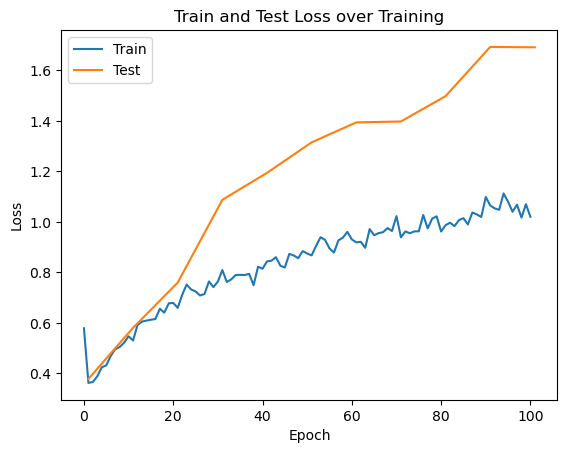

In [9]:
# Set dropout probabilities
p_drop_input = 0.2
p_drop_hidden = 0.5

#set a
a=0.5

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        
        #PRelu
        x=PRelu(x,a)
        
        noise_py_x = dropout_model(x, w_h, w_h2, w_o,p_drop_input,p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                
                #PRelu
                x=PRelu(x,a)
                
                noise_py_x = dropout_model(x, w_h, w_h2, w_o,p_drop_input,p_drop_hidden)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Task: Compare the results with the previous models.

* The mean train loss is higher compared to both Section 1 (without dropout) and Section 2 (with dropout). This suggests that the model is finding it even more challenging to fit the training data with PReLU activation.
* The mean test loss is consistently higher than in both Section 1 and Section 2. This indicates that the model's generalization performance is worse when using PReLU activation.

While dropout showed improvements in the previous section, PReLU activation seems to have a negative impact on the model's performance in this case. 

## 4 Convolutional layers

In this exercise we want to create a similar neural network to LeNet from Yann LeCun. LeNet was designed for handwritten and machine-printed character recognition. It relies on convolutional layers that transform the input image by convolution with multiple learnable filters. LeNet contains convolutional layers paired with sub-sampling layers as displayed in Figure 1. The Subsampling is done via max pooling which reduces an area of the image to one pixel with the maximum value of the area. Both functions are already available in pytorch:

    from torch.nn.functional import conv2d , max_pool2d

    convolutional_layer = rectify(conv2d(previous_layer , weightvector)) 
    # reduces (2,2) window to 1 pixel
    subsampling_layer = max_pool_2d(convolutional_layer, (2, 2))
    out_layer = dropout(subsample_layer , p_drop_input)


## 4.1 Create a Convolutional network

Now we can design our own convolutional neural network that classifies the handwritten numbers from MNIST.

Implementation task:
* Make sure that the input image has the correct shape:

    trainX = trainX.reshape(-1, 1, 28, 28) #training data
    testX = testX.reshape(-1, 1, 28, 28) #test data
    
* Replace the first hidden layer h with 3 convolutional layers (including subsampling and dro- pout)
* Connect the convolutional layers to the vectorized layer h2 by flattening the input with torch.reshape.
* The shape of the weight parameter for conv2d determines the number of filters f, the number of input images picin, and the kernel size k = (kx,ky). You can initialize the weights with

    init_weights((f, pic_in, k_x, k_y))
    
Make a neural network with

    Convolutional layer | first | second | third
            f              32       64      128
            pic_in         1        32      64
            kx             5        5       2
            ky             5        5       2


and add the weight vectors to the params list.
* In Section 4.2 you will determine the number of output pixels of the CNN. Use it to adjust the size of the rectifier layer to
    
    w_h2 = init_weights((number_of_output_pixel , 625))

* Use a pre-softmax output layer with 625 inputs and 10 outputs (as before).

In [10]:
# define the neural network
def LeNetmodel(x, w_h, w_h2, w_o,p_drop_input , p_drop_hidden):
    x=x.reshape ( -1 , 1, 28 , 28) 
    
    #h
    convolutional_layer = rectify ( conv2d ( x , w_h ))
    subsampling_layer = max_pool2d ( convolutional_layer , (2 , 2) )
    out_layer = dropout ( subsampling_layer , p_drop_input )
    
    convolutional_layer = rectify ( conv2d ( out_layer , w_h2 ))
    subsampling_layer = max_pool2d ( convolutional_layer , (2 , 2) )
    out_layer = dropout ( subsampling_layer , p_drop_input )
    
    convolutional_layer = rectify ( conv2d ( out_layer , w_o ))
    subsampling_layer = max_pool2d ( convolutional_layer , (2 , 2) )
    out_layer = dropout ( subsampling_layer , p_drop_input )
    
    #h2
    #print(out_layer.shape)#[100,128,1,1]
    h=out_layer.reshape(100,128)
    old_w_h2 = init_weights (( 128 , 625) )
    old_w_o = init_weights((625, 10))
    
    
    #h = rectify(x @ w_h)
    h2 = rectify(h @ old_w_h2)
    pre_softmax = h2 @ old_w_o
    return pre_softmax
     


Epoch: 0
Mean Train Loss: 2.91e+00
Mean Test Loss:  2.30e+00
Epoch: 10
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 20
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 30
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 40
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 50
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 60
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 70
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 80
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 90
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 100
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00


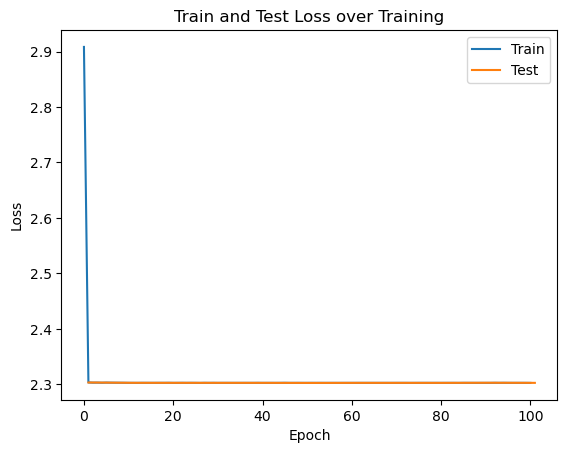

In [11]:
# Set dropout probabilities
p_drop_input = 0.2
p_drop_hidden = 0.5

#set a
a=0.5

# initialize weights

# input shape is (B, 784)
#w_h = init_weights((784, 625))
# hidden layer with 625 neurons
#w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
#w_o = init_weights((625, 10))
# output shape is (B, 10)
#init_weights ((f, pic_in , k_x , k_y ))
w1=init_weights ((32, 1 , 5 , 5 ))
w2=init_weights ((64, 32 , 5 , 5 ))
w3=init_weights ((128, 64 , 2 , 2 ))

optimizer = RMSprop(params=[w1, w2, w3])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch
        
        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        
        #PRelu
        x=PRelu(x,a)
        
        noise_py_x = LeNetmodel(x, w1, w2, w3,p_drop_input,p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                
                #PRelu
                x=PRelu(x,a)
                
                noise_py_x = LeNetmodel(x, w1, w2, w3,p_drop_input,p_drop_hidden)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
     

In [12]:
# to make some changes of 4.2
#we choose to add one conv layer

# define the neural network
def LeNetmodel2(x, w_h, w_h2, w_o,p_drop_input , p_drop_hidden):
    x=x.reshape ( -1 , 1, 28 , 28) 
    
    w_h3=init_weights ((256, 128 , 1 , 1 ))
    #h
    convolutional_layer = rectify ( conv2d ( x , w_h ))
    subsampling_layer = max_pool2d ( convolutional_layer , (2 , 2) )
    out_layer = dropout ( subsampling_layer , p_drop_input )
    
    convolutional_layer = rectify ( conv2d ( out_layer , w_h2 ))
    subsampling_layer = max_pool2d ( convolutional_layer , (2 , 2) )
    out_layer = dropout ( subsampling_layer , p_drop_input )
    
    convolutional_layer = rectify ( conv2d ( out_layer , w_o ))
    subsampling_layer = max_pool2d ( convolutional_layer , (2 , 2) )
    out_layer = dropout ( subsampling_layer , p_drop_input )
    
    convolutional_layer = rectify ( conv2d ( out_layer , w_h3 ))
    subsampling_layer = max_pool2d ( convolutional_layer , (1 , 1) )
    out_layer = dropout ( subsampling_layer , p_drop_input )

    #h2
    #print(out_layer.shape)#[100,128,1,1]
    h=out_layer.reshape(100,256)
    old_w_h2 = init_weights (( 256 , 625) )
    old_w_o = init_weights((625, 10))
    
    
    #h = rectify(x @ w_h)
    h2 = rectify(h @ old_w_h2)
    pre_softmax = h2 @ old_w_o
    return pre_softmax




Epoch: 0
Mean Train Loss: 2.72e+00
Mean Test Loss:  2.30e+00
Epoch: 10
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 20
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 30
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 40
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 50
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 60
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 70
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 80
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 90
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 100
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00


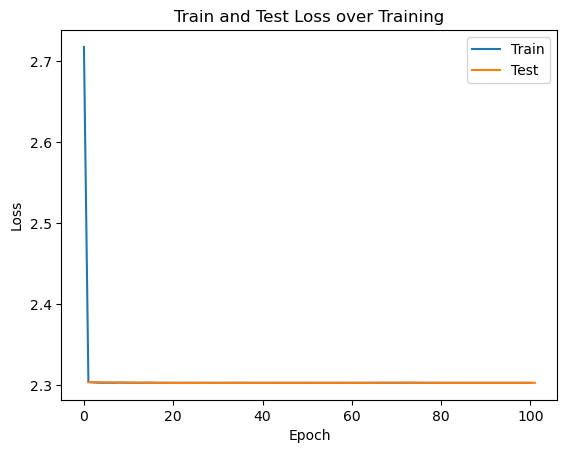

In [13]:
# Set dropout probabilities
p_drop_input = 0.2
p_drop_hidden = 0.5

#set a
a=0.5

# initialize weights

# input shape is (B, 784)
#w_h = init_weights((784, 625))
# hidden layer with 625 neurons
#w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
#w_o = init_weights((625, 10))
# output shape is (B, 10)
#init_weights ((f, pic_in , k_x , k_y ))
w1=init_weights ((32, 1 , 5 , 5 ))
w2=init_weights ((64, 32 , 5 , 5 ))
w3=init_weights ((128, 64 , 2 , 2 ))

optimizer = RMSprop(params=[w1, w2, w3])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch
        
        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        
        #PRelu
        x=PRelu(x,a)
        
        noise_py_x = LeNetmodel2(x, w1, w2, w3,p_drop_input,p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                
                #PRelu
                x=PRelu(x,a)
                
                noise_py_x = LeNetmodel2(x, w1, w2, w3,p_drop_input,p_drop_hidden)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## 4.2 Application of Convolutional network

Task:

* Draw a sketch of the network (like Figure 1) and note the sizes of the filter images (This will help you to determine how many pixels there are in the last convolution layer).
* Train the model. Then, plot:
    * one image from the test set
    * its convolution with 3 filters of the first convolutional layer
    * the corresponding filter weights (these should be 5 by 5 images).
    
Finally, choose one of the following tasks:

* add or remove one convolutional layer (you may adjust the number of filters)
* increase the filter size (you may plot some pictures i
* apply a random linear shift to the trainings images. Does this reduce overfitting?
* use unisotropic filters kx! = ky
* create a network architecture of your choice and see if you can improve on the previous results and compare the new test error.

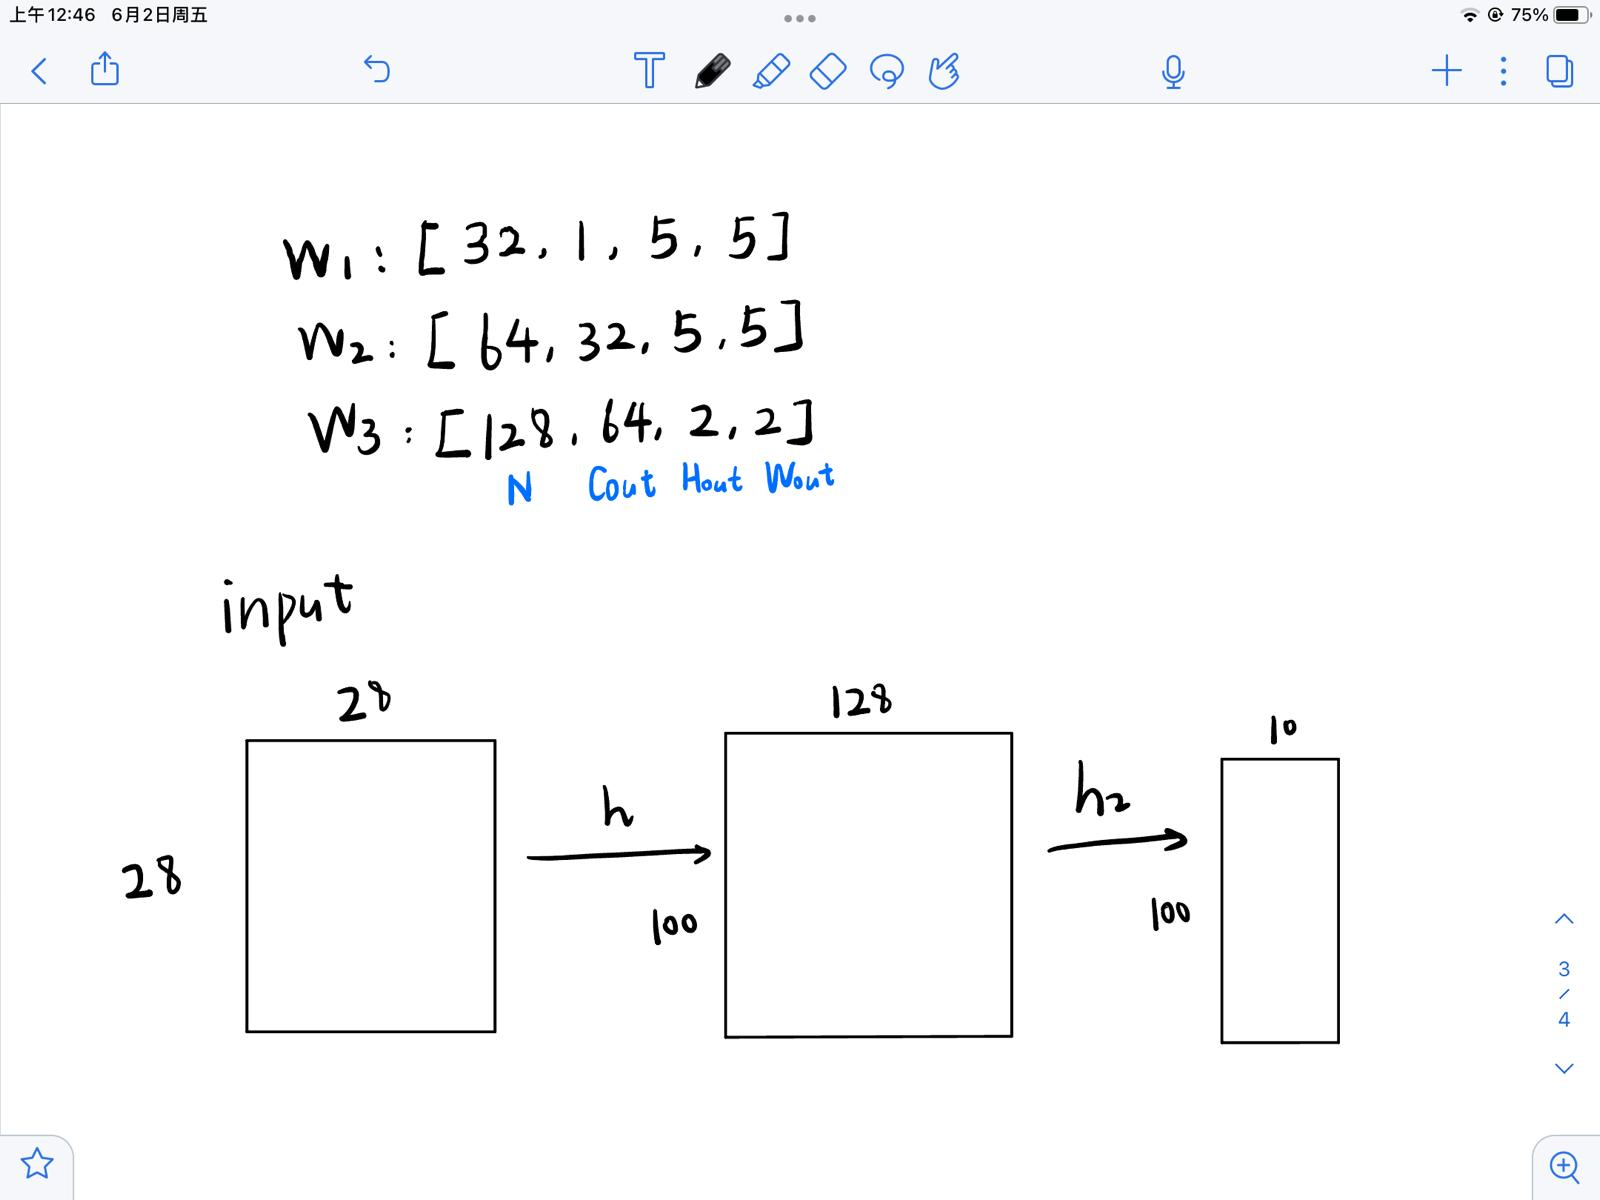

Ideally you should create an overview table that lists the test errors from all sections.

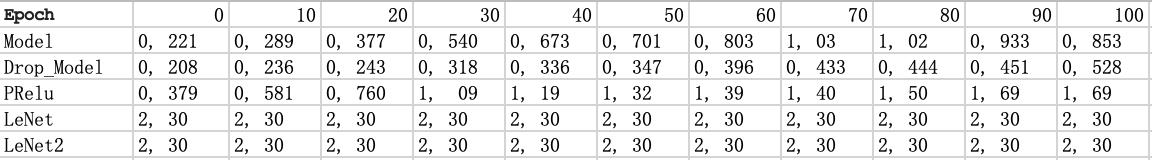